# Preperation

### Imports

In [1]:
import os
import sys
import pandas as pd
from transformers import DataCollatorWithPadding
import torch
import random

from sklearn.metrics import confusion_matrix

In [2]:
import sys, os
sys.path.append(os.path.abspath('../../src'))

from helper_functions.path_resolver import DynamicPathResolver
from helper_functions import visualization as visual
from model_training import bert

### Seed

In [3]:
def set_seed(seed=42):  
    random.seed(seed)             
    os.environ['PYTHONHASHSEED'] = str(seed)  

    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  

set_seed(42)  

### Paths

In [4]:
dpr = DynamicPathResolver(marker="README.md")

train_csv = dpr.path.data.preprocessed.data_mail.train_processed_balanced_csv
test_csv  = dpr.path.data.preprocessed.data_mail.test_processed_en_de_csv

models_folder = dpr.path.models.bert._path
output_dir    = dpr.path.models.bert.results._path
log_dir       = dpr.path.models.bert._logs._path

Project Root: c:\Users\ilian\Documents\Projects\git_projects\university\phishing_detection


# Training

### Get test data

In [5]:
test_data = pd.read_csv(test_csv)
print("\n=== Updated Class Distribution ===")
print(test_data['label'].value_counts(), "\n")


=== Updated Class Distribution ===
label
0    2000
1    2000
Name: count, dtype: int64 



### Train config

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
config = {
    'data_amount': 20000,
    'max_len': 256,
    'batch_size': 64,
    'num_epochs': 10,
    'learning_rate': 2e-05,
    'lr_scheduler_type': "linear",
    'weight_decay': 0.01,
    'logging_steps': 10,
    'evaluation_strategy': "epoch",
    'save_strategy': "epoch",
    'warmup_steps': 500,
    'early_stopping_patience': 3,
}

In [8]:
bert_type = 'bert-base-multilingual-cased' # 'bert-base-uncased' # distilbert-base-uncased

### Get model and tokenizer

In [9]:
special_tokens = ["[EMAIL]", "[URL]"] # None

In [10]:
model, tokenizer = bert.create_model_and_tokenizer(bert_type, special_tokens, device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Tokenizer vocabulary size: 119549


In [11]:
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=config['learning_rate'], 
    betas=(0.9, 0.999), 
    eps=1e-08
)

scheduler = None 

### Prepare data

In [12]:
mail_data = bert.load_data(train_csv, config['data_amount'])


=== Updated Class Distribution ===
label
0    10000
1    10000
Name: count, dtype: int64 



In [13]:
train_data, eval_data = bert.split_data(mail_data, eval_size=0.2)
train_data.head(5)

Training data size: 16000
Evaluation data size: 4000


,text,label,char_count_processed
13500,CNN Alerts: My Custom Alert [SEP] CNN Alerts: ...,1,609
4606,[Python-Dev] Auto-Assignment [SEP] I just impl...,0,453
5079,[Perl Jobs] One-off contractor for simple HTTP...,0,2308
11798,Verabschieden Sie sich von Einsamkeit [SEP] Er...,1,382
19966,verhindern [SEP] Fernseher Encarta Zune gegrün...,1,894


In [14]:
train_dataset, eval_dataset, test_dataset = bert.create_custom_datasets(
    train_data, eval_data, test_data, tokenizer, config['max_len']
)

In [15]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Verify preprocess

In [16]:
for i in range(5):
    sample = train_dataset[i]
    print(f"Sample {i}:")
    print("Input IDs:", sample["input_ids"])
    print("Attention Mask:", sample["attention_mask"])
    print("Label:", sample["labels"])
    print("-" * 40)

Sample 0:
Input IDs: tensor([   101,  31117,  59340,  26215,    131,  11590, 101590,  59340,  10976,
           102,  31117,  59340,  26215,    131,  11590, 101590,  59340,  10976,
         59340,  10976,  15729,    131,  11590, 101590,  59340,  10976,  11065,
         11337,  10128,  12277,  13028,  10149,  10472,  10529,  50725,  10111,
         26133,  10114,  25157,  23307,  10114,  33884,  10116,    117,    129,
         53012,  10203,  10249,    131,  10669,    131,  10296,    116,  78336,
         10929,    143, 100673,  11369,  53317,  42622,  14703,  11065,  10529,
         25577,  10114,  26286,  10531,  79515,  10188,  31117,    119,  10212,
         10146,    169,  14493,  10108,  20442,  31117,    119,  10212,  12229,
         52790, 100529,    119,  11469,  59251,  20442, 100529,    171,  64791,
         19353,    119,  11469,  42141,  20442,  11372,  10976,  67136,  10345,
         38387,  10345,  10114,  15826,  20664,  31505,  47116,  10112,  10188,
         31391,  66

In [17]:
for i in range(5):
    print(f"Sample {i}:")
    print("Input IDs length:", len(train_dataset[i]['input_ids']))
    print("Attention Mask length:", len(train_dataset[i]['attention_mask']))
    print("Label:", train_dataset[i]['labels'])
    print("-" * 40)


Sample 0:
Input IDs length: 256
Attention Mask length: 256
Label: tensor(1)
----------------------------------------
Sample 1:
Input IDs length: 256
Attention Mask length: 256
Label: tensor(0)
----------------------------------------
Sample 2:
Input IDs length: 256
Attention Mask length: 256
Label: tensor(0)
----------------------------------------
Sample 3:
Input IDs length: 256
Attention Mask length: 256
Label: tensor(1)
----------------------------------------
Sample 4:
Input IDs length: 256
Attention Mask length: 256
Label: tensor(1)
----------------------------------------


### Train model

In [ ]:
trainer = bert.train_evaluate(model, tokenizer, train_dataset, eval_dataset, config, data_collator, output_dir, log_dir)

### Load model

In [19]:
model, tokenizer = bert.load_model_from_checkpoint(models_folder, '2500', device)

Model loaded from c:\Users\ilian\Documents\Projects\git_projects\university\phishing_detection\models\bert\checkpoint-2500 onto cpu.


### Evaluate on Test

In [20]:
true_labels, predicted_labels, probs = bert.evaluate_on_test(model, test_dataset, data_collator, config['batch_size'], device)

# Visualization

### Extract metrics

In [28]:
metrics = visual.extract_all_metrics_from_events(log_dir)
extracted_metrics = visual.extract_loss_and_accuracy_metrics(metrics)

Existing Metrics Key Paths:
train - loss - steps
train - loss - values
train - grad_norm - steps
train - grad_norm - values
train - learning_rate - steps
train - learning_rate - values
train - epoch - steps
train - epoch - values
train - train_loss - steps
train - train_loss - values
train - train_accuracy - steps
train - train_accuracy - values
train - train_precision - steps
train - train_precision - values
train - train_recall - steps
train - train_recall - values
train - train_runtime - steps
train - train_runtime - values
train - train_samples_per_second - steps
train - train_samples_per_second - values
train - train_steps_per_second - steps
train - train_steps_per_second - values
train - total_flos - steps
train - total_flos - values
eval - loss - steps
eval - loss - values
eval - accuracy - steps
eval - accuracy - values
eval - precision - steps
eval - precision - values
eval - recall - steps
eval - recall - values
eval - runtime - steps
eval - runtime - values
eval - samples_pe

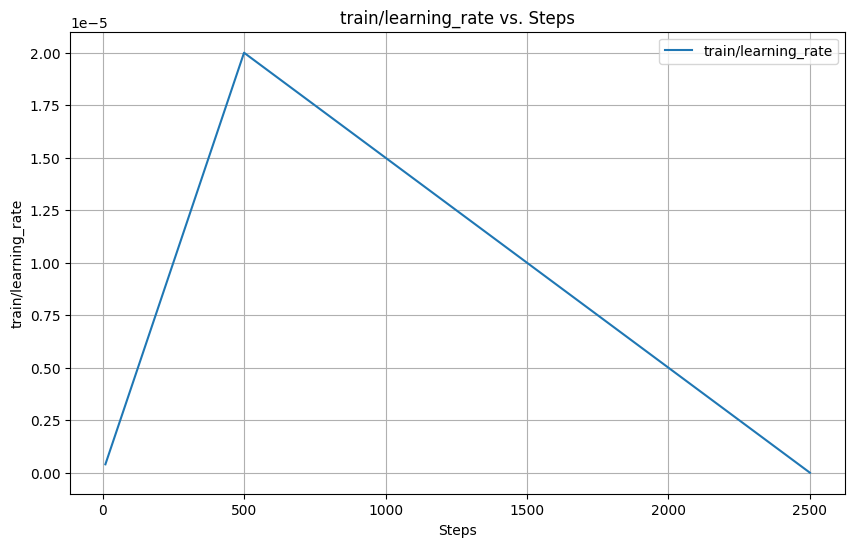

In [29]:
scalar_tag = "train/learning_rate"
visual.plot_scalar_metric(log_dir, scalar_tag)

### Loss x Epochs & Accuracy x Epochs

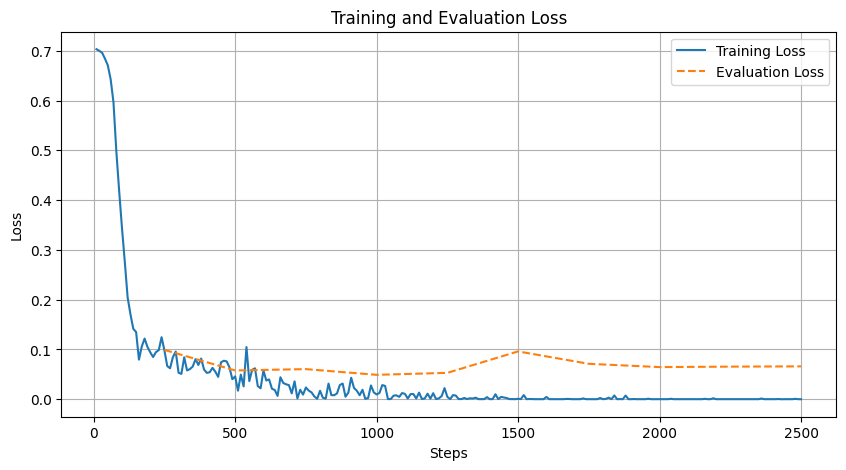

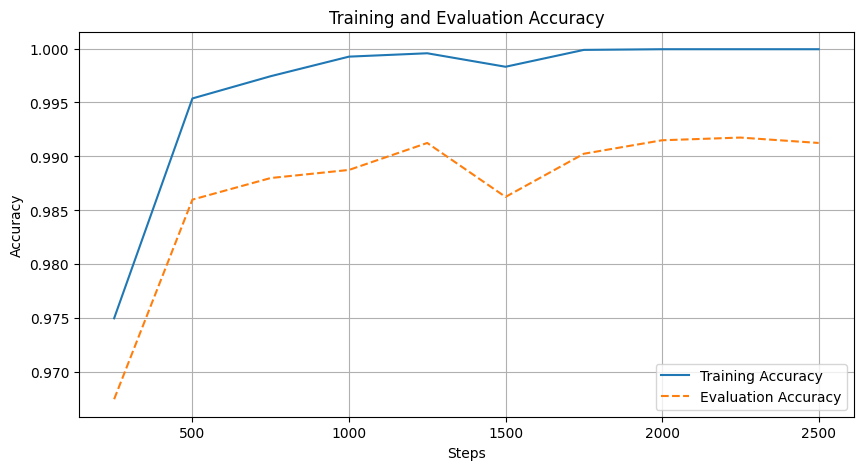

In [30]:
visual.plot_loss_accuracy(extracted_metrics, output_dir)

### Confusion Matrix

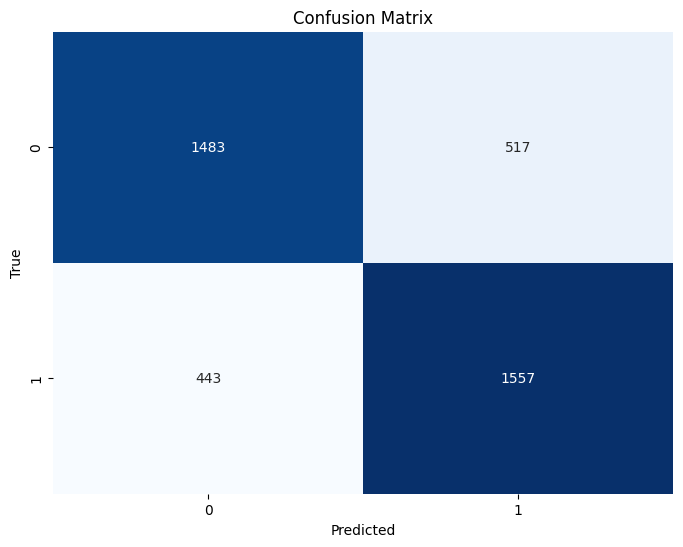

In [22]:
cm = confusion_matrix(true_labels, predicted_labels)
visual.plot_confusion_matrix(cm, output_dir, "test")

### ROC

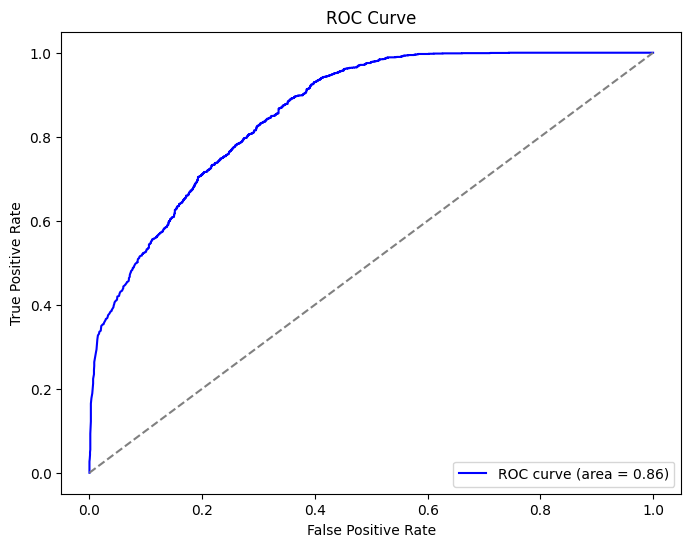

In [23]:
visual.plot_roc_curve(true_labels, probs, output_dir)

### Precision - Recall

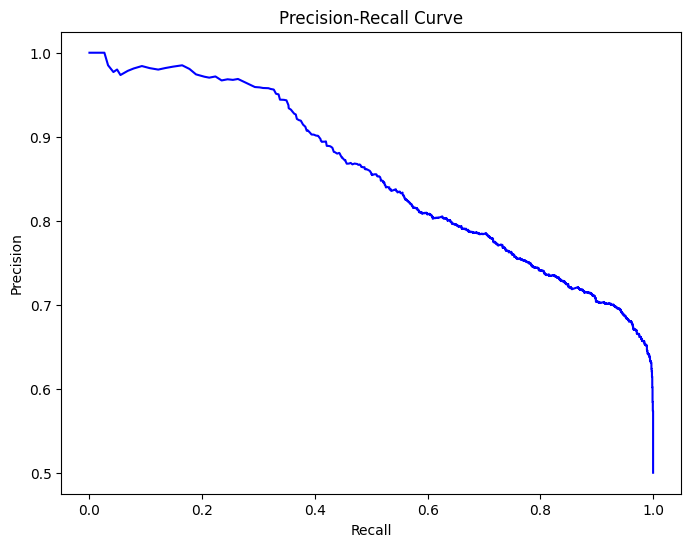

In [24]:
visual.plot_precision_recall(true_labels, probs, output_dir)

### Classification Report

In [25]:
visual.display_classification_report(true_labels, predicted_labels, target_names=["Legitimate", "Phishing"])

,precision,recall,f1-score,support
Legitimate,0.769990,0.7415,0.755476,2000.00
Phishing,0.750723,0.7785,0.764359,2000.00
accuracy,0.760000,0.7600,0.760000,0.76
macro avg,0.760356,0.7600,0.759918,4000.00
weighted avg,0.760356,0.7600,0.759918,4000.00


### Inference on samples

In [ ]:
s_texts = [
    # Legitimate (0) - Customer addressed with name
    "Dear Frank, your shipment is on its way. Track your order with the tracking number 1234567890. Thank you for shopping with us!",
    
    # Phishing (1) - Generic addressing with urgency
    "Dear user, urgent: Your shipment is delayed. Track your order immediately by clicking this link and providing personal details.",
    
    # Legitimate (0) - Shipment tracking with a proper number
    "Your package has been shipped and is expected to arrive tomorrow. Use the tracking number 9876543210 to track your order in real time.",
    
    # Phishing (1) - Phishing attempt with urgency and a vague request
    "Urgent! Your package has been delayed. Click here to provide your personal information and confirm your tracking number to avoid further delays.",
    
    # Legitimate (0) - Monthly bank statement review
    "Dear Frank, your monthly bank statement is available for review. Please log in to your account to view the full details.",
    
    # Phishing (1) - Urgent account compromise message
    "Your bank account has been compromised! Click this link immediately to verify your identity and secure your account before any further issues occur.",
    
    # Legitimate (0) - Real job application confirmation
    "Hello Frank, we have received your application for the software engineering position. Our team will review it and contact you within a week.",
    
    # Phishing (1) - Fake job application attempt
    "Congratulations, Frank! You've been shortlisted for a job. Please provide your personal information to finalize your application process.",
    
    # Legitimate (0) - Real company promotion (e.g., Easter gift)
    "Happy Easter, Frank! Enjoy a special 15% discount on your next purchase at our store. Use the promo code EASTER15.",
    
    # Phishing (1) - Fake prize scam
    "Congratulations! You've won a $1,000 gift card. To claim your prize, please provide your bank details here."
]

s_true_labels = [
    0, 1, 0, 1, 0, 1, 0, 1, 0, 1
]


In [ ]:
s_true_labels, s_predicted_labels, s_probs = bert.inference(
    model, s_texts, s_true_labels, tokenizer,  config['max_len'], device
)

In [ ]:
visual.display_inference_results(s_texts, s_true_labels, s_predicted_labels, s_probs, class_names=["Legitimate", "Phishing"])

In [ ]:
visual.display_classification_report(s_true_labels, s_predicted_labels, target_names=["Legitimate", "Phishing"])